<a href="https://colab.research.google.com/github/AhmedSaleh627/Eagles_MegaProject/blob/main/Task_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install Dependences

In [ ]:
!pip install ultralytics
!pip install easyocr

#Import Necessary Libraries

In [2]:
import pandas as pd
import numpy as np
import joblib
import easyocr
import cv2
import os
from google.colab.patches import cv2_imshow
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator
from IPython.display import HTML
from joblib.parallel import nullcontext
from zmq.constants import NULL

#Change The Root Path To Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
desired_path = '/content/drive/MyDrive/Colab Data/'
os.chdir(desired_path)

#Load Our YOLOv8 and Color Classification models

In [4]:
YOLO_model = YOLO("YOLO Shape Detector/runs/detect/train/weights/best.pt")

In [5]:
COLOR_model = joblib.load('Color Classification/random_forest_model.pkl')

#Using Kmeans Model To separate Our Images to Three Clusters

In [6]:
def getKmeans(clusters, image: np.ndarray):
    datapoints = image.reshape((-1, 3)).astype(np.float32)  # It is a colored image, so each pixel has 3 features
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret, label, center = cv2.kmeans(datapoints, clusters, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # Compute the histogram of cluster labels
    label_counts = np.bincount(label.ravel())

    # Find the cluster label with the largest count (background cluster)
    background_cluster_label = np.argmax(label_counts)

    # Set the count of the background cluster to zero to find the second largest cluster
    label_counts[background_cluster_label] = 0

    # Find the second largest cluster label
    second_largest_cluster_label = np.argmax(label_counts)

    # Set the count of the second largest cluster to zero to find the third largest cluster
    label_counts[second_largest_cluster_label] = 0

    # Find the third largest cluster label
    third_largest_cluster_label = np.argmax(label_counts)

    # Create masks for the second and third largest clusters
    second_largest_cluster_mask = (label == second_largest_cluster_label).reshape(image.shape[:2])
    third_largest_cluster_mask = (label == third_largest_cluster_label).reshape(image.shape[:2])

    # Apply the masks to the original image to extract the second and third largest clusters
    second_largest_cluster_image = np.zeros_like(image)
    third_largest_cluster_image = np.zeros_like(image)

    second_largest_cluster_image[second_largest_cluster_mask] = image[second_largest_cluster_mask]
    third_largest_cluster_image[third_largest_cluster_mask] = image[third_largest_cluster_mask]

    return second_largest_cluster_image, third_largest_cluster_image


#Image Preparation Functions

#1- Image Crop Function

In [7]:
def crop(image):
  image_copy = image.copy()

  # Copy the original image onto the copy
  image_copy[:] = image
  results = YOLO_model.predict(image, conf=0.6)

  annotator = Annotator(image)
  boxes = results[0].boxes
  cropped_images = []

  for box in boxes:
    b = box.xyxy[0] # Get box coordinates
    x1, y1, x2, y2 = map(int, b) # Convert to integer coordinates
    c = box.cls
    conf = box.conf[0]

    # Crop the region defined by the bounding box
    cropped_roi = image_copy[(y1-12):(y2+12), (x1-12):(x2+12)]
    cropped_images.append(cropped_roi)

    annotator.box_label(b, f'{YOLO_model.names[int(c)]} {conf:.2f}')

  # Display the image with the drawn bounding boxes
  cv2_imshow(image)
  print()

  return cropped_images

#2-color Calculation Function

In [8]:
def get_color(cropped_image):

  masked_image, _ = getKmeans(3, cropped_image)
  print()

  non_black_pixels_mask = np.any(masked_image != [0, 0, 0], axis=-1)

  # Extract the non-black pixels
  non_black_pixels = masked_image[non_black_pixels_mask]

  if len(non_black_pixels) > 0:
    # Calculate the average color of non-black pixels
    average_color = np.mean(non_black_pixels, axis=0).astype(int)
    return average_color[::-1]  # Return in RGB format
  else:
    return None

#3-Letter Extraction Function

In [ ]:
def get_letter(cropped_image):
  list = []
  counts = {}
  _, mask = getKmeans(3, cropped_image)
  non_black_pixels_mask = np.any(mask != [0, 0, 0], axis=-1)

  # Extract the non-black pixels
  mask[non_black_pixels_mask] = [255, 255, 255]
  mask = cv2.bitwise_not(mask)
  gray = np.full_like(mask, 128, dtype=np.uint8)
  mask = cv2.bitwise_and(mask,gray)
  accuracy = 0
  count = 0
  while True:
    angle = 15
    height, width = mask.shape[:2]
    center = (width // 2, height // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    mask = cv2.warpAffine(mask, rotation_matrix, (width, height))
    reader = easyocr.Reader(['en'])
    result = reader.readtext(mask)
    count = count + 1
    if count > 24:
      break
    if result == []:
      continue
    list.append(result[0][1])
    accuracy = result[0][2]
  for element in list:
    if element in counts:
      counts[element] += 1
    else:
      counts[element] = 1

  # Find the most frequently appended element
  if counts == {}:
    return 'NULL'
  most_frequent_element = max(counts, key=counts.get)

  return most_frequent_element


#Testing

#Inference


0: 640x640 1 heptagon, 100.2ms
Speed: 9.3ms preprocess, 100.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


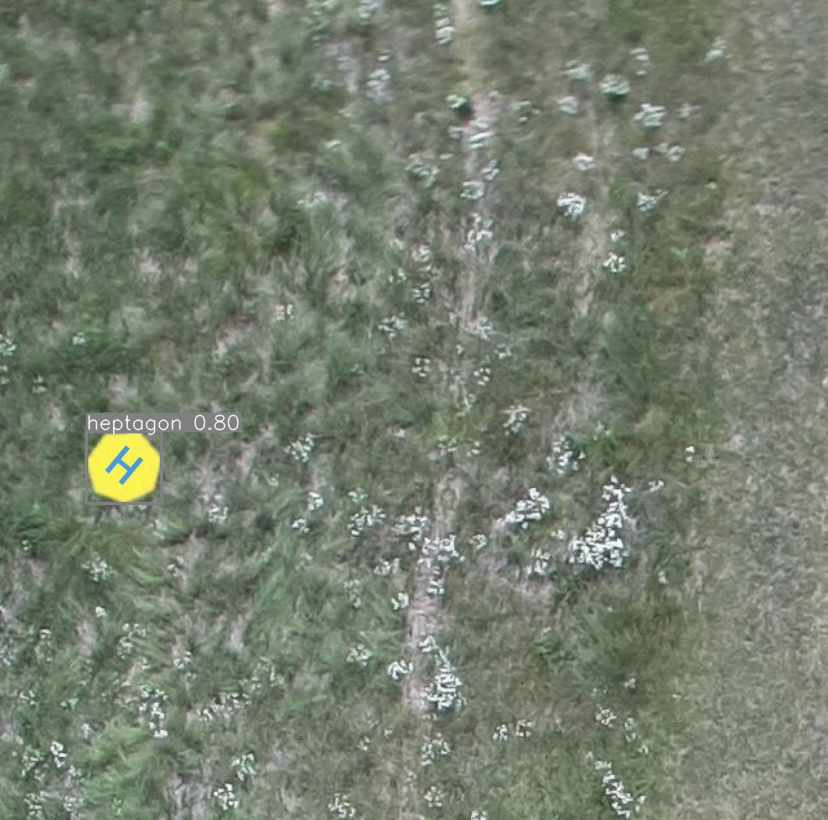

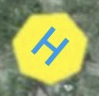



[243 238  89]




The predicted color is Yellow


























 the letter is H




0: 640x640 1 hexagon, 98.2ms
Speed: 5.3ms preprocess, 98.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


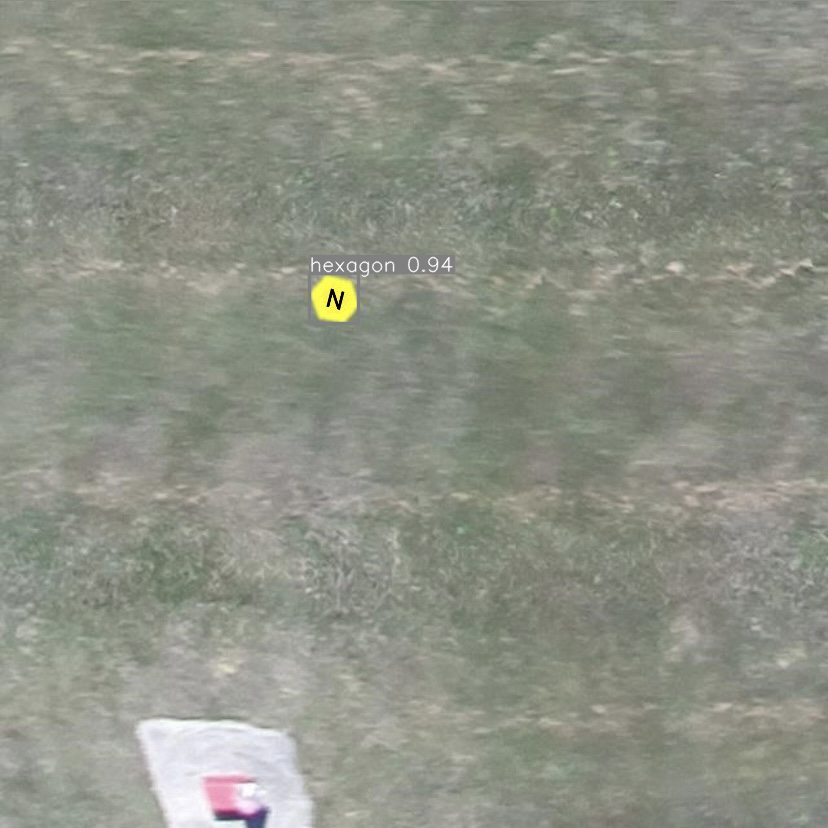

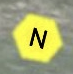



[242 242  92]




The predicted color is Yellow


























 the letter is N




0: 640x640 1 hexagon, 97.6ms
Speed: 4.6ms preprocess, 97.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


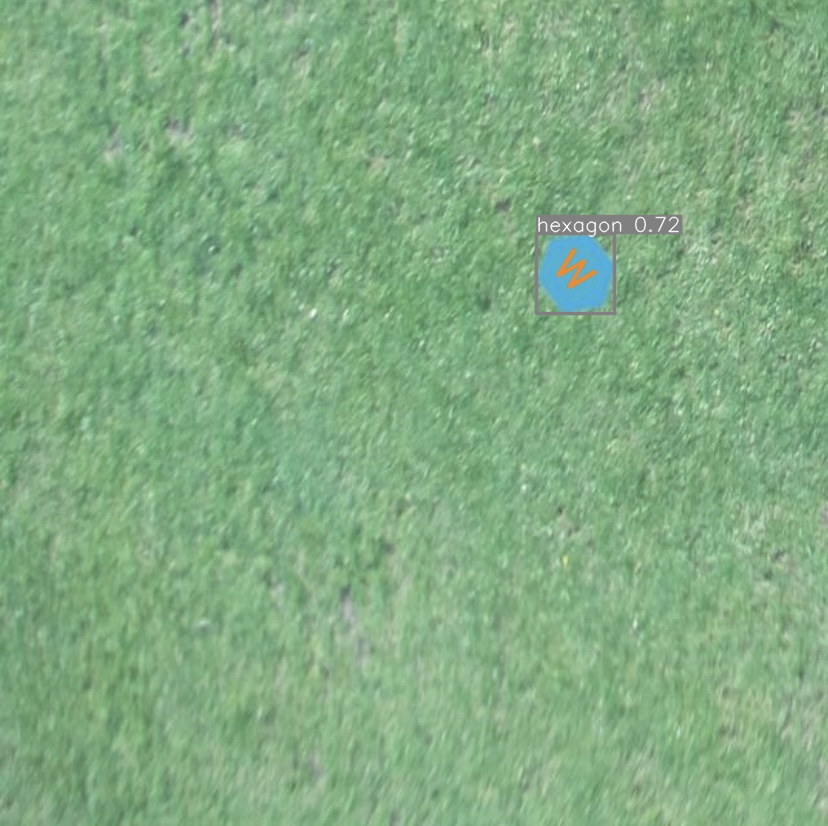

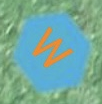



[ 95 174 206]




The predicted color is Blue


























In [ ]:
for i in range(1,21):
  image = cv2.imread(f'test imgs/image{i}.jpg')
  cropped_images = crop(image)
  for cropped_image in cropped_images:
    cv2_imshow(cropped_image)
    print()
    color = get_color(cropped_image)
    print(color)
    print()
    html_color = f'<div style="background-color: rgb({color[0]}, {color[1]}, {color[2]}); width: 13px; height: 13px;"></div>'
    display(HTML(html_color))
    print()
    print(f'The predicted color is {COLOR_model.predict([color])[0]}')
    print()
    letter = get_letter(cropped_image)
    print(f' the letter is {letter}')
    print()